# Предсказание оттока клиентов банка

**Цель исследования:** натренировать модель оттока, которая лучше всех сможет генерализовать общую зависимость оттока.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import re
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    f1_score, 
    confusion_matrix,
    precision_recall_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/kaggle/input/adengi-internship/sample_submission.csv
/kaggle/input/adengi-internship/train.csv
/kaggle/input/adengi-internship/test.csv


In [2]:
PATH_TRAIN_CSV = '/kaggle/input/adengi-internship/train.csv'
PATH_TEST_CSV = '/kaggle/input/adengi-internship/test.csv'
PATH_SUBMISSUION_CSV = '/kaggle/working/submission.csv'

## Загрузка данных

### Тренировочная выборка

In [3]:
train = pd.read_csv(PATH_TRAIN_CSV)
train.head()

monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000735         0.952894            NaN              -0.388291   
1       -0.000742         0.952894            NaN              -0.388291   
2       -0.000742         0.952894            NaN              -0.388291   
3       -0.000742         0.952894            NaN              -0.388291   
4       -0.000742         0.952894            NaN              -0.388291   

   main_agreement_term  requested_period_days  requested_amount  \
0            -0.340659              -0.389028         -1.053530   
1            -1.145865              -1.294731         -0.436189   
2            -0.685747              -1.113590         -0.259806   
3             0.176974              -1.385301          1.239449   
4            -1.145865              -1.657011          0.357534   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0       -0.629296         -0.61762    -0.340659         -0.539615 -0.619312   
1       -0.020140         -0.61762    -1.145865         -0.539615  1.354330   
2        0.153905         -0.61762    -0.685747         -0.502706  1.354330   
3        1.633284         -0.61762     0.176974         -0.465796  1.354330   
4        0.763061         -0.61762    -1.145865         -0.133607  1.354330   

    cnt_ext      term     price  elecs_sum  recurents_sum   tamount    issues  \
0       NaN       NaN       NaN  -0.063933      -0.143015 -0.434972  0.347703   
1       NaN       NaN       NaN  -0.063933      -0.143015 -0.434972  0.347703   
2       NaN       NaN       NaN  -0.063933      -0.143015 -0.429509  0.347703   
3       NaN       NaN       NaN  -0.063933      -0.143015 -0.413118  0.347703   
4  1.407752 -0.612324 -0.705103  -0.063933      -0.143015 -0.320236  0.347703   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.347703 -0.502878         -0.218265    -0.185707    1.837622   
1  -0.347703 -0.502878         -0.218265    -0.185707    2.262600   
2  -0.347703 -0.484111         -0.218265    -0.185707    2.262600   
3  -0.347703 -0.427809         -0.218265    -0.185707    2.262600   
4  -0.347703 -0.108766         -0.218265    -0.185707    2.262600   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1   464867     111035      11             0   
1                  2       1  4569010     604426      11             0   
2                  2       1   985489     334703      11             4   
3                  2       6  2247534     362893      11             0   
4                  2       1  4695006     537669      11            11   

   interface  type  repayment_type  client_type settlement client_type.1  \
0          0     2               3            1   г Москва      repeated   
1          2     1               0            1   г Москва      repeated   
2          2     2               3            1    г Пермь      repeated   
3          2     2               1            1   г Самара      repeated   
4          2     1               2            1   г Москва      repeated   

          region  gender  loan_order  have_extension  contact_cases  \
0       г Москва    male           2               0            NaN   
1       г Москва  female          14               0            NaN   
2  край Пермский    male          10               0            NaN   
3  обл Самарская  female           2               1            NaN   
4       г Москва  female          17               0            NaN   

            created_at            closed_at             start_dt  churn  
0  2022-12-23 17:50:25  2022-12-31 16:09:23                  NaN      0  
1  2024-06-29 22:26:08  2024-07-27 16:21:49                  NaN      0  
2  2023-04-10 21:06:38  2023-05-10 07:51:18                  NaN      0  
3  2023-10-01 00:13:16  2024-01-12 17:40:14  2024-01-12 17:29:21      0  
4  2024-07-15 10:40:35  2024-07-18 12:20:08                  NaN   

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float64
 1   work_experience        float64
 2   requested_sum          float64
 3   main_agreement_amount  float64
 4   main_agreement_term    float64
 5   requested_period_days  float64
 6   requested_amount       float64
 7   req_app_amount         float64
 8   approved_amount        float64
 9   period_days            float64
 10  days_finish_loan       float64
 11  ag                     float64
 12  cnt_ext                float64
 13  term                   float64
 14  price                  float64
 15  elecs_sum              float64
 16  recurents_sum          float64
 17  tamount                float64
 18  issues                 float64
 19  principal              float64
 20  interest               float64
 21  overdue_interest       float64
 22  overdue_fee       

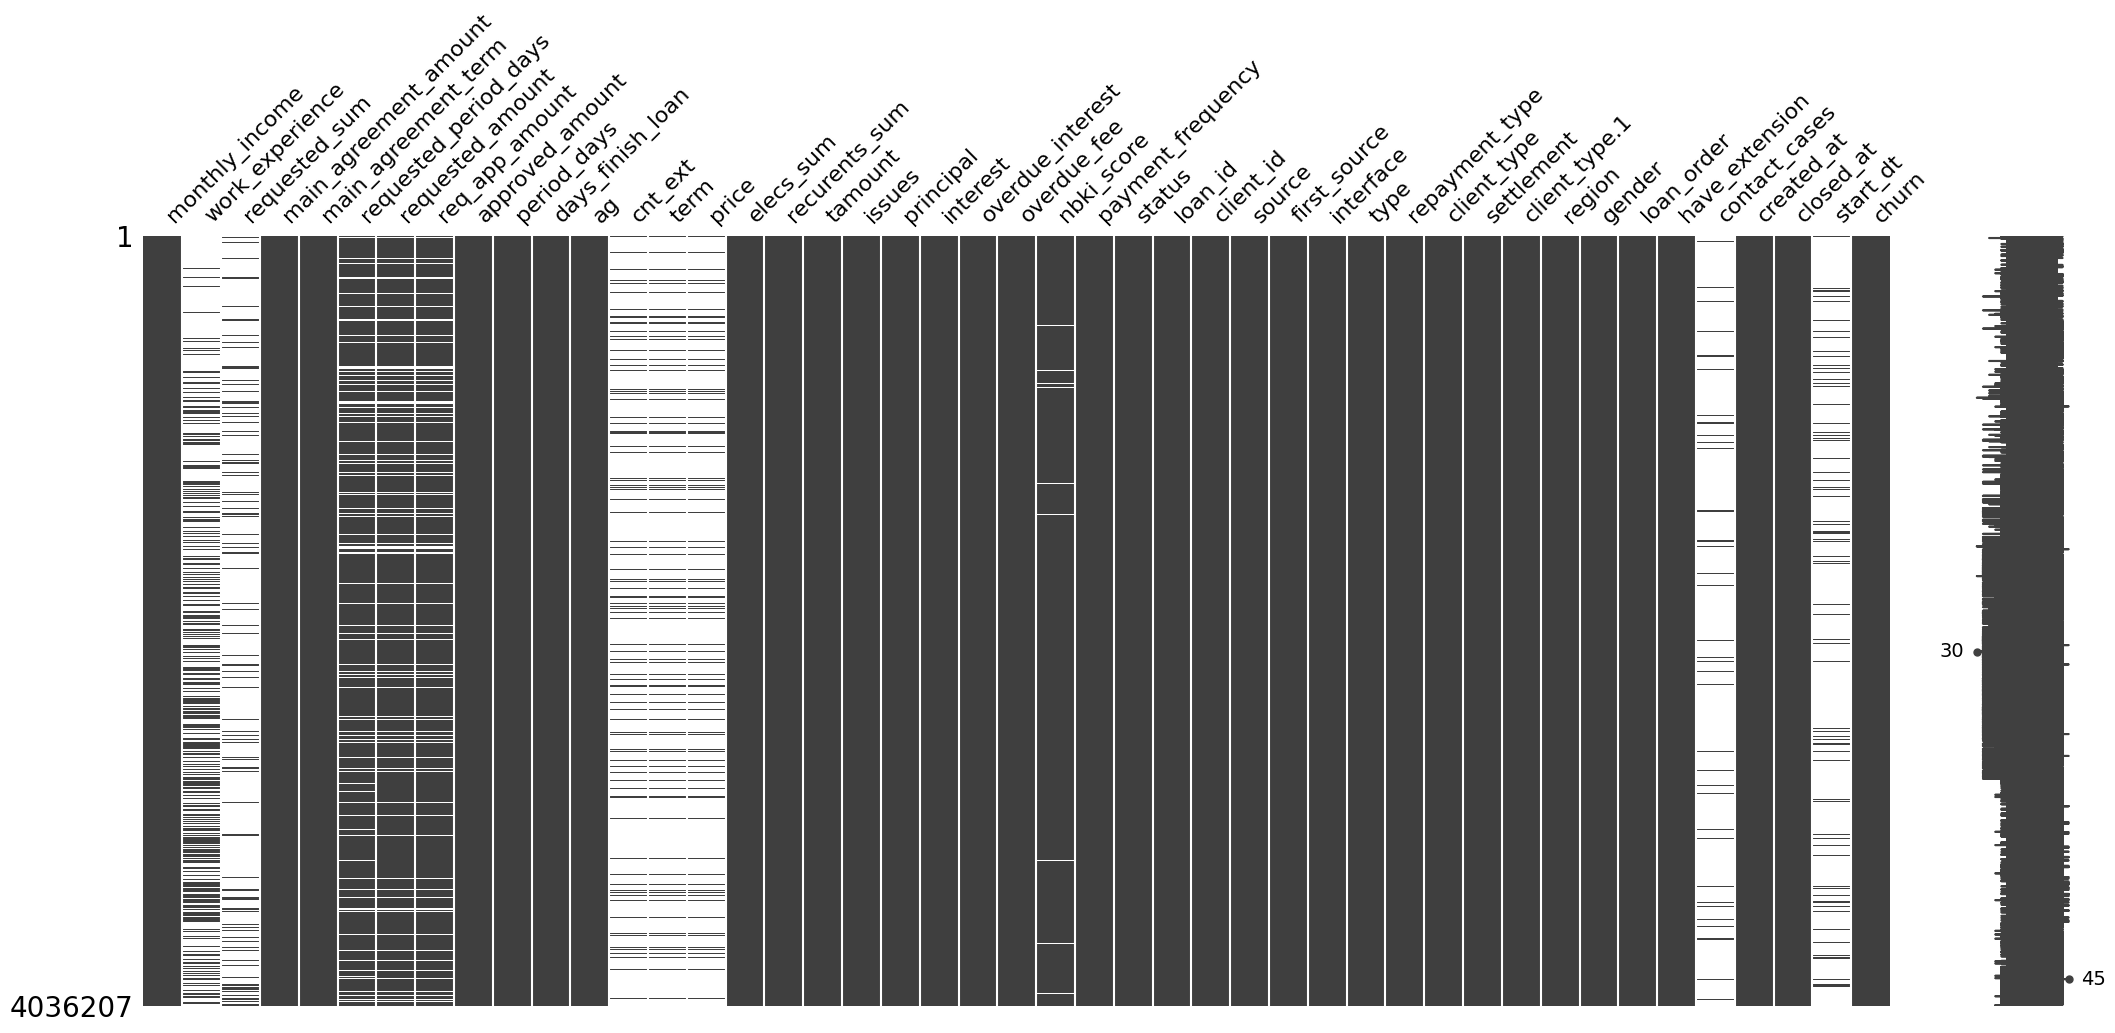

In [5]:
msno.matrix(train)
plt.show()

### Тестовая выборка

In [6]:
test = pd.read_csv(PATH_TEST_CSV)
test.head()

monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000742         0.952894            NaN              -0.089509   
1       -0.000742         0.952894            NaN               4.242822   
2       -0.000749        -1.653445            NaN              -0.687072   
3       -0.000749        -1.653445            NaN              -0.687072   
4       -0.000745              NaN            NaN               0.806835   

   main_agreement_term  requested_period_days  requested_amount  \
0             0.176974              -1.385301          0.181151   
1             8.114011                    NaN          1.239449   
2             0.176974              -1.385301         -1.053530   
3             0.176974               0.426103          1.239449   
4            -0.340659              -0.389028         -0.083423   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0        0.414972        -0.350380     0.176974         -0.539615  1.354330   
1       -1.760586         4.593562     8.114011          0.586136  1.562082   
2       -0.455251        -0.884860     0.176974         -0.539615 -0.619312   
3        1.807328        -0.884860     0.176974         -0.539615 -0.515436   
4       -0.368229         0.451340    -0.340659         -0.152062 -0.099932   

   cnt_ext  term  price  elecs_sum  recurents_sum   tamount    issues  \
0      NaN   NaN    NaN  -0.063933      -0.143015 -0.245566  0.095187   
1      NaN   NaN    NaN  -0.063933      -0.143015  3.180674 -3.566293   
2      NaN   NaN    NaN  -0.063933      -0.143015 -0.613451  0.600219   
3      NaN   NaN    NaN  -0.063933      -0.143015  0.111392  0.100238   
4      NaN   NaN    NaN  -0.063933      -0.143015  0.293513 -0.662360   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.095187 -0.477855         -0.218265    -0.185707    2.262600   
1   3.566293  2.207618         -0.189042    -0.118661    2.262600   
2  -0.600219 -0.490367         -0.218265    -0.185707    0.783852   
3  -0.100238 -0.490367         -0.218265    -0.185707    0.783852   
4   0.662360 -0.502878         -0.218265    -0.185707   -0.495416   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1  4057275     594851      11             0   
1                  2       5   548313     143027      11             0   
2                  2       1  1978430     766940       0             0   
3                  2       1  2884196     873858      11             0   
4                  2       1  3647374     437895      11             0   

   interface  type  repayment_type  client_type                  settlement  \
0          0     2               1            1                    г Москва   
1          2     2               3            1                   г Коркино   
2          2     2               2            0              г Екатеринбург   
3          2     2               1            1                 г Черемхово   
4          0     2               1            1  г Лысьва поселок Кормовище   

  client_type.1                  region  gender  loan_order  have_extension  \
0      repeated                г Москва    male          15               0   
1      repeated         обл Челябинская  female           5               0   
2           new        обл Свердловская    male           1               0   
3      repeated           обл Иркутская  female           3               0   
4      repeated  Пермский край Пермский    male           4               0   

   contact_cases           created_at start_dt  
0            NaN  2024-04-29 18:20:22      NaN  
1            NaN  2023-01-17 04:59:57      NaN  
2            NaN  2023-08-29 14:04:47      NaN  
3            NaN  2023-12-14 15:47:39      NaN  
4            NaN  2024-03-13 05:47:49      NaN

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   monthly_income         1348680 non-null  float64
 1   work_experience        463225 non-null   float64
 2   requested_sum          163790 non-null   float64
 3   main_agreement_amount  1348743 non-null  float64
 4   main_agreement_term    1348743 non-null  float64
 5   requested_period_days  1200882 non-null  float64
 6   requested_amount       1209772 non-null  float64
 7   req_app_amount         1209772 non-null  float64
 8   approved_amount        1348743 non-null  float64
 9   period_days            1348743 non-null  float64
 10  days_finish_loan       1348743 non-null  float64
 11  ag                     1348743 non-null  float64
 12  cnt_ext                151701 non-null   float64
 13  term                   151701 non-null   float64
 14  price             

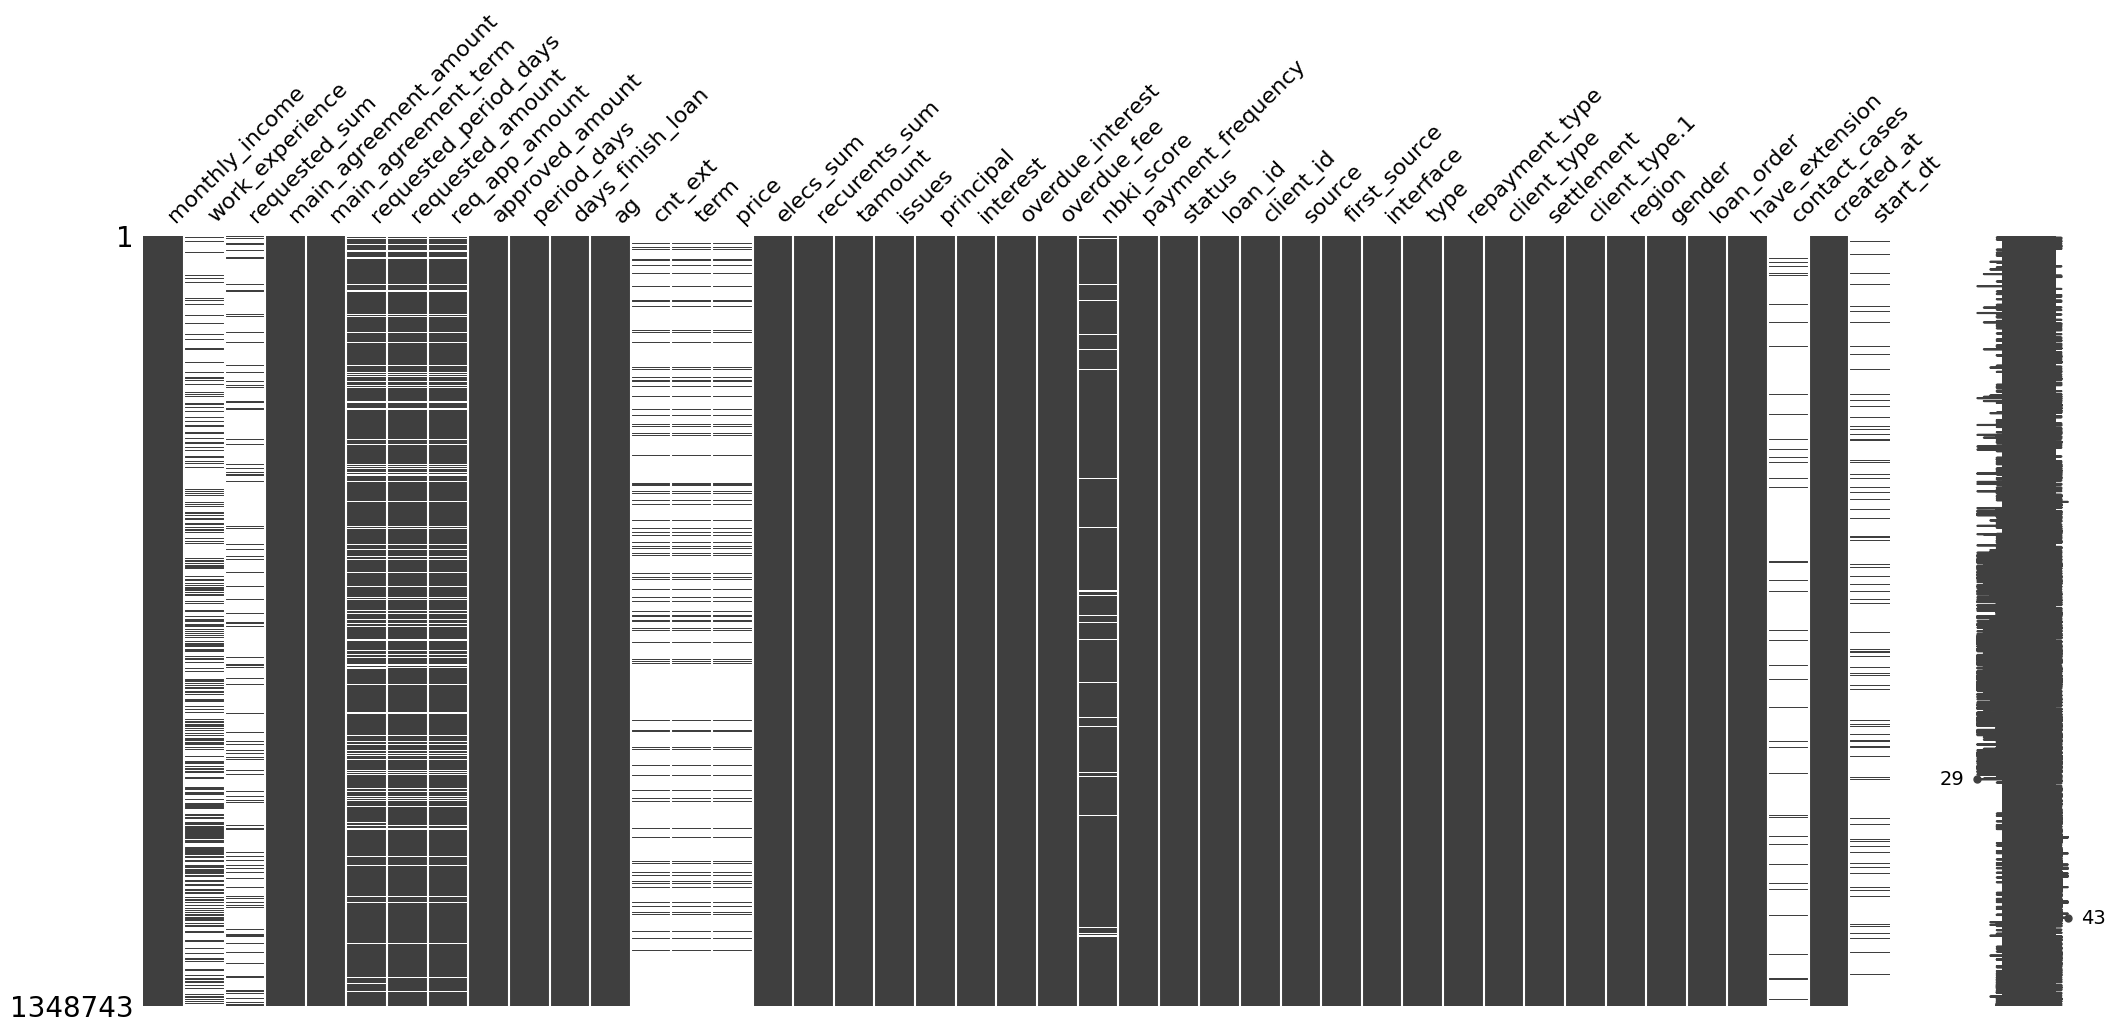

In [8]:
msno.matrix(test)
plt.show()

**Итог раздела:**
- в датафрейме `train` содержится 44 столбца и 4 036 207 строк, есть большое количество пропусков, нужно поменять тип данных в некоторых колонках;
- в датафрейме `test` 42 столбца и 1 348 743 строк, так же есть большое количество пропусков и неверные типы данных.

## Предобработка тренировочной выборки

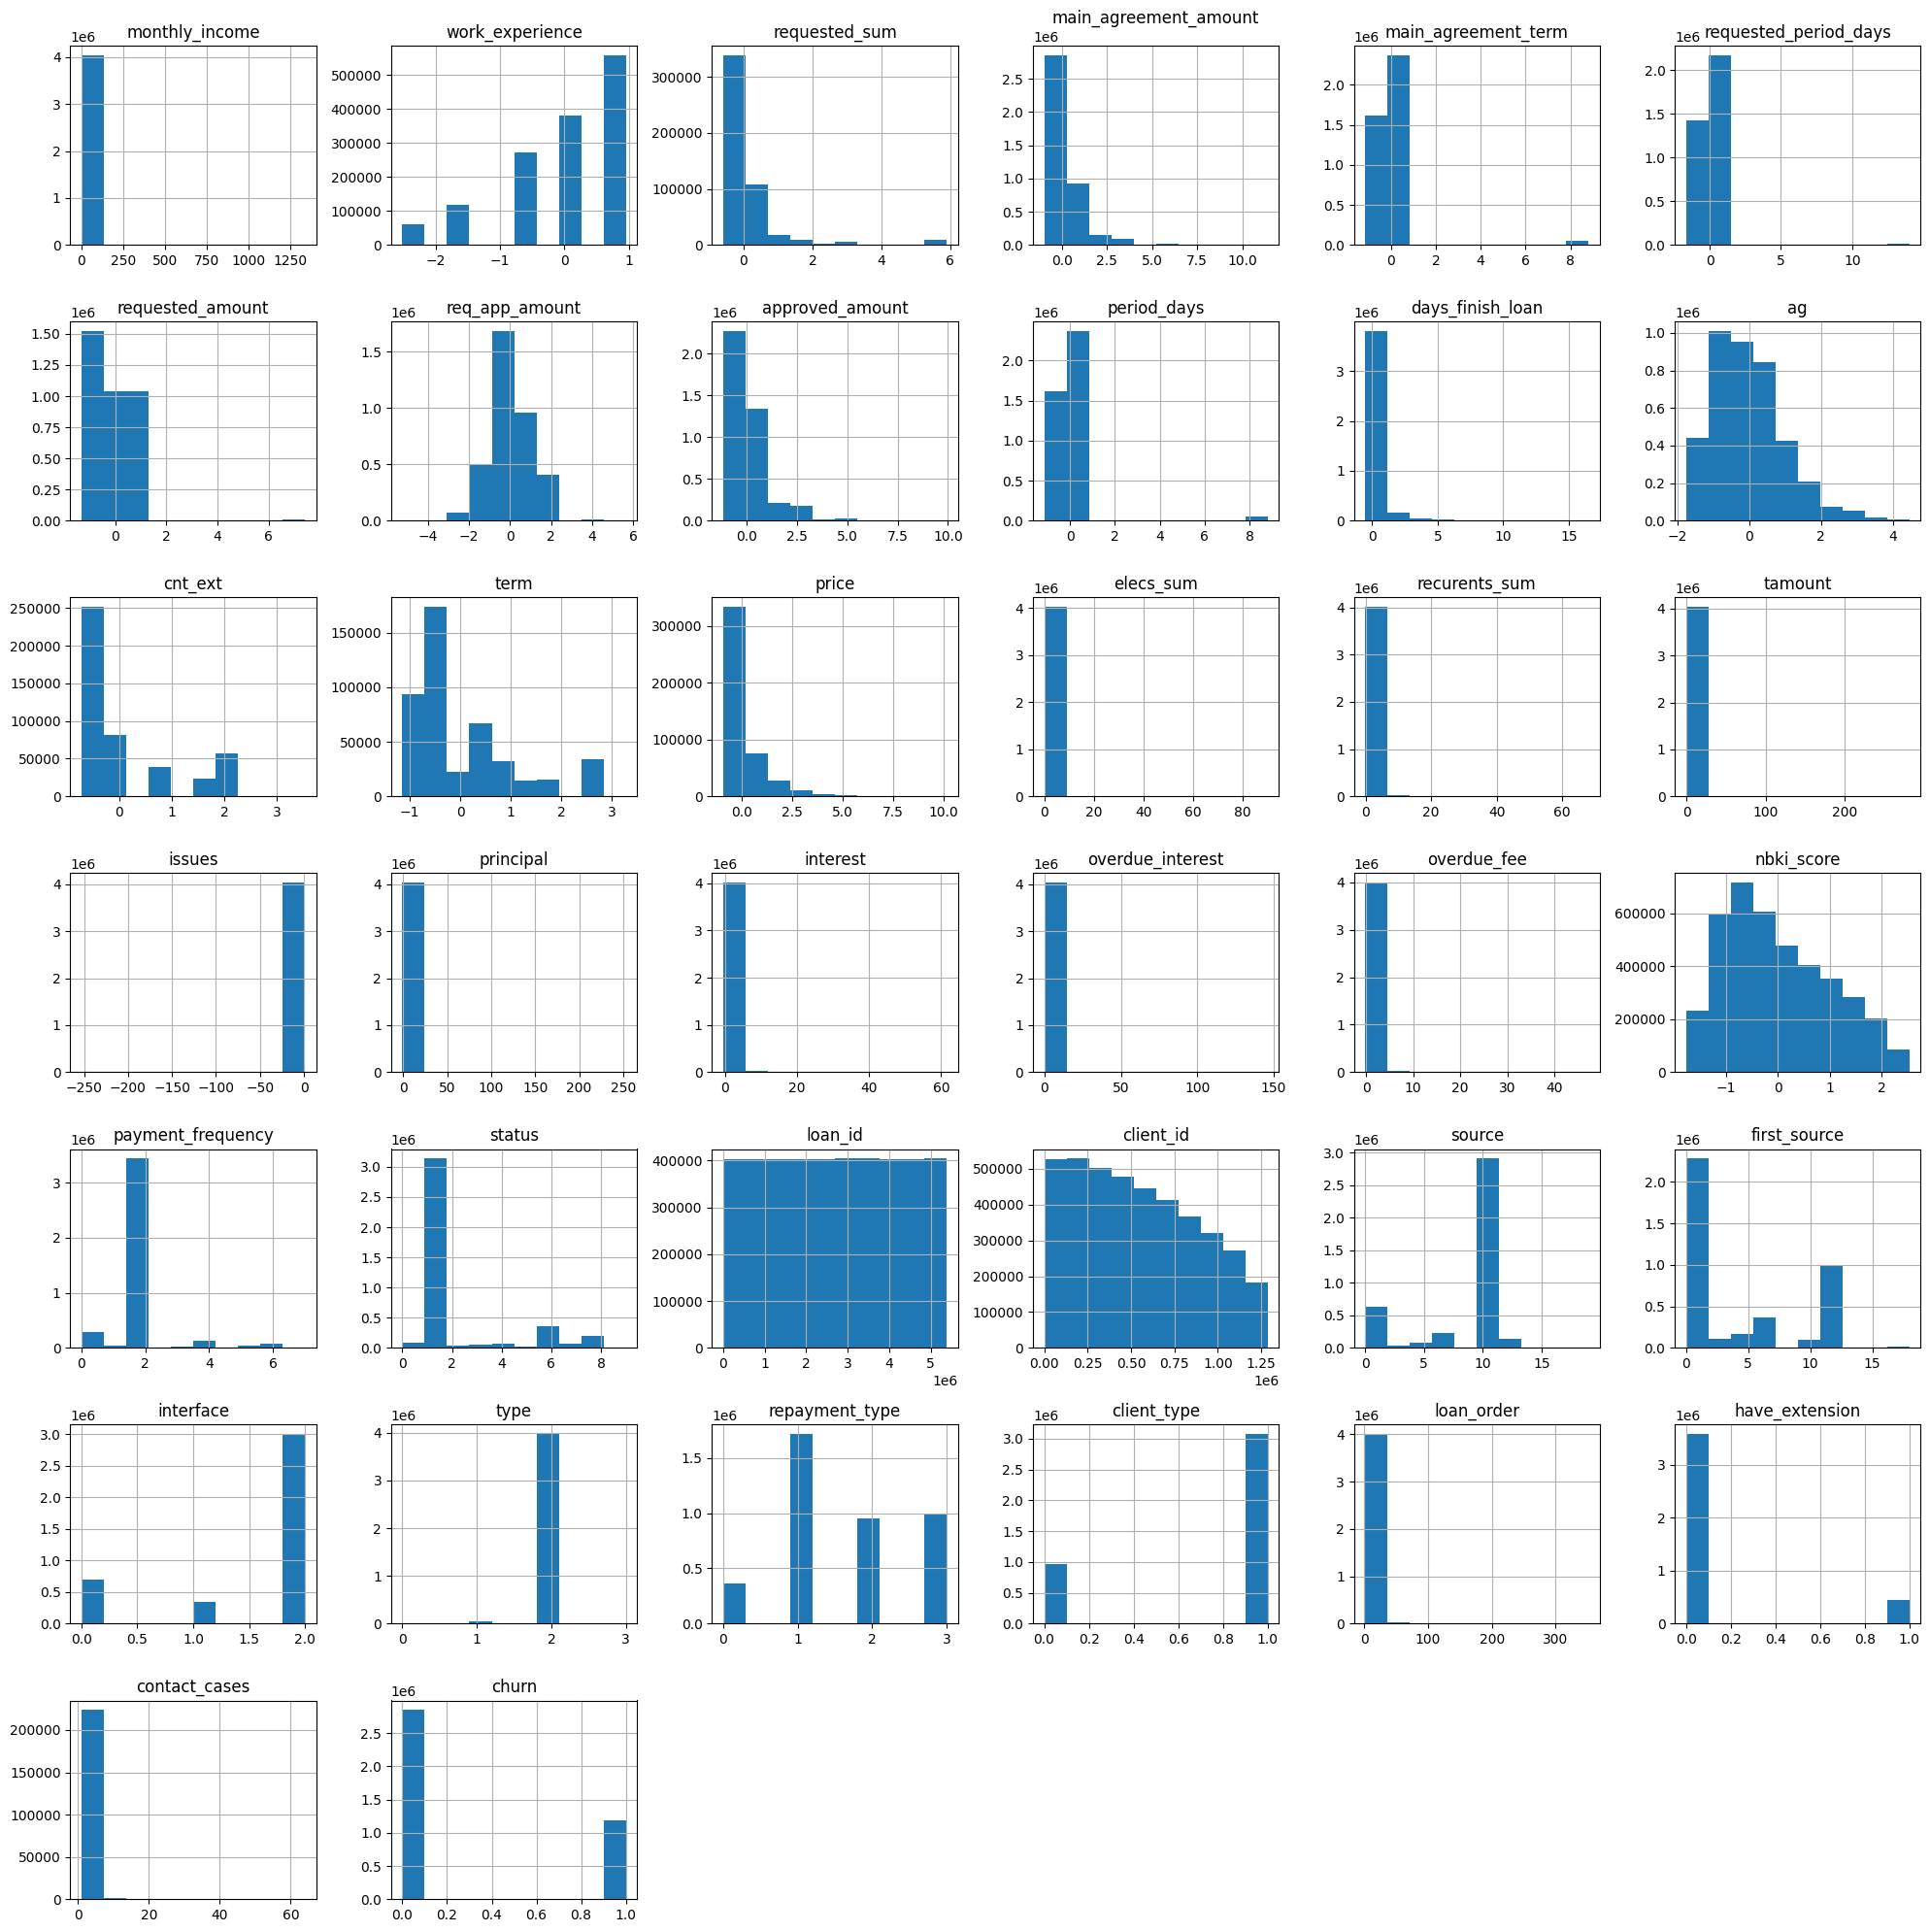

In [9]:
# Гистограммы всех числовых признаков
train.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

In [10]:
# Обработка выбросов и аномальных значений
train = train.query('main_agreement_amount < 8')
train = train.query('tamount < 3')
train = train.query('recurents_sum < 10')
train = train.query('elecs_sum < 10')
train = train.query('interest < 4')
train = train.query('overdue_interest < 4')
train = train.query('overdue_interest < 4')
train = train.query('monthly_income < 200')

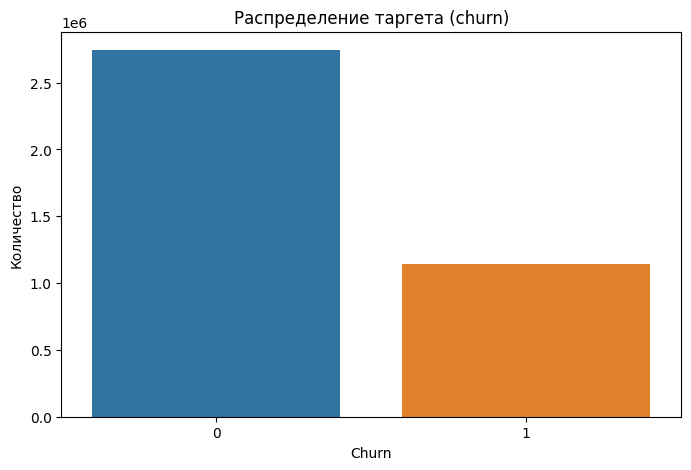

In [11]:
# Построение графика распределения целевого признака
plt.figure(figsize=(8, 5))
sns.countplot(x=train["churn"])

plt.title("Распределение таргета (churn)")
plt.xlabel("Churn")
plt.ylabel("Количество")

plt.show()

Таргет распределён неравномерно, со значительным перекосом в сторону 0 класса, т.е. наблюдений, где клиент остался значительно больше. Эту ситуацию нужно будет учесть при обучении модели.

In [12]:
train.isna().sum()

monthly_income                 0
work_experience          2545390
requested_sum            3409687
main_agreement_amount          0
main_agreement_term            0
requested_period_days     395557
requested_amount          388273
req_app_amount            388273
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  3484657
term                     3484657
price                    3484794
elecs_sum                      0
recurents_sum                  0
tamount                        0
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 80274
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

In [13]:
# Функция для обработки столбцов с датами
def clean_date(df):
    df_columns = ['created_at', 'start_dt']
    for col in df_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[col] = df[col].fillna(df['start_dt'])
            df[col] = df[col].astype('int64') // 10**9
    return df

In [14]:
train = clean_date(train)

In [15]:
# Добавление новых признаков

# Временные признаки
train['early_repayment'] = train['period_days'] - train['days_finish_loan']
train['extension_to_term_ratio'] = train['term'] / train['main_agreement_term']

# Платежное поведение
train['interest_to_principal_ratio'] = train['interest'] / train['principal']
train['overdue_ratio'] = (train['overdue_interest'] + train['overdue_fee']) / train['principal']
train['repayment_ratio'] = (train['tamount'] - train['issues']) / train['tamount']


# Кредитное поведение
train['approval_ratio'] = train['approved_amount'] / train['requested_amount']
train['rejected_amount'] = train['requested_amount'] - train['approved_amount']
train['avg_loan_per_client'] = train.groupby('client_id')['approved_amount'].transform('mean')
train['is_first_extension'] = (train['cnt_ext'] == 1).astype(int)

# Признаки рискованности клиента
train['risk_score'] = (
        (train['nbki_score'] * -1) +
        (train['overdue_ratio'] * 2) +
        (train['have_extension'] * 1.5)
    )
train['penalties_to_principal_ratio'] = (train['elecs_sum'] + train['recurents_sum']) / train['principal']
train['overdue_to_approved_ratio'] = train['issues'] / train['approved_amount']

# Финансовая нагрузка
train['total_debt_burden'] = (train['elecs_sum'] + train['recurents_sum']) / train['monthly_income']
train['disposable_income_ratio'] = 1 - train['total_debt_burden']
train['residual_income'] = train['monthly_income'] - (train['elecs_sum'] + train['recurents_sum'])
train['debt_to_income_ratio'] = (train['approved_amount'] + train['issues']) / train['monthly_income']

# Поведенческие признаки
train['is_digital_client'] = (train['source'].isin([11, 12]) | (train['interface'] == 'mobile')).astype(int)

In [16]:
# Функция для очистки названий регионов
def clean_region_name(region):
    region = region.lower()
    cleaned = re.sub(r'\b(обл|аобл|якутия|район|деревня|область|респ|республика|ао|край|г)\b', '', region, flags=re.IGNORECASE)
    cleaned = re.sub(r'[/]', '', cleaned)
    cleaned = ' '.join(dict.fromkeys(cleaned.split()))
    return cleaned.strip()

train['region'] = train['region'].apply(clean_region_name)

In [17]:
# Группировка регионов
def group_regions(region):
    federal_districts = {
        'Центральный': ['москва', 'московская', 'владимирская', 'ивановская',
                        'калужская', 'костромская', 'орловская', 'рязанская',
                        'смоленская', 'тверская', 'тульская', 'ярославская'],
        
        'Северо-Западный': ['санкт-петербург', 'ленинградская', 'вологодская',
                            'калининградская', 'новгородская', 'псковская',
                            'карелия', 'коми'],
        
        'Приволжский': ['татарстан', 'башкортостан', 'нижегородская',
                        'самарская', 'саратовская', 'ульяновская',
                        'пензенская', 'оренбургская', 'кировская',
                        'чувашия', 'мордовия', 'марий эл'],
        
        'Южный': ['краснодарский', 'ставропольский', 'волгоградская',
                  'астраханская', 'калмыкия', 'адыгея'],
        
        'Северо-Кавказский': ['дагестан', 'ингушетия', 'северная осетия - алания',
                              'кабардино-балкарская', 'карачаево-черкесская', 
                              'чеченская'],
        
        'Уральский': ['свердловская', 'челябинская', 'тюменская',
                      'ханты-мансийский', 'ямало-ненецкий', 'курганская'],
        
        'Сибирский': ['новосибирская', 'омская', 'томская', 'иркутская',
                      'красноярский', 'алтайский', 'кемеровская',
                      'алтай', 'тыва', 'хакасия'],
        
        'Дальневосточный': ['приморский', 'хабаровский', 'амурская',
                            'сахалинская', 'камчатский', 'чукотский',
                            'саха', 'магаданская'],
        
        'Крымский': ['крым', 'севастополь']
    }
    
    for district, regions in federal_districts.items():
        if region in regions:
            return district
    return 'Другие'

In [18]:
train['region_group'] = train['region'].apply(group_regions)

In [19]:
# Добавление признаков-меток пропущенных значений
missing_cols = ['work_experience', 'requested_sum', 'nbki_score']
for col in missing_cols:
    train[f'{col}_missing'] = train[col].isna().astype(int)

In [20]:
# Функция для заполнения пропущенных значений
def fill_missing_values(df):
    df['work_experience'] = df['work_experience'].fillna(
        df.groupby('status')['work_experience'].transform('median')
    ).fillna(df['work_experience'].median())

    df['requested_sum'] = df['requested_sum'].fillna(
        df['approved_amount'] * (df['requested_sum'].mean() / df['approved_amount'].mean()))

    df['requested_amount'] = df['requested_amount'].fillna(df['requested_sum'])\
                                                  .fillna(df['requested_amount'].median())

    df['req_app_amount'] = df['req_app_amount'].fillna(
        df['requested_amount'] - df['approved_amount']
    ).fillna(df['req_app_amount'].median())

    df['requested_period_days'] = df.groupby('type')['requested_period_days'].transform(lambda x: x.fillna(x.median()))
    
    df['elecs_sum'] = df.groupby('repayment_type')['elecs_sum'].transform(lambda x: x.fillna(x.median()))
    
    df['recurents_sum'] = df.groupby('repayment_type')['recurents_sum'].transform(lambda x: x.fillna(x.median()))

    df['tamount'] = df['tamount'].fillna(df['principal'] + df['interest'] + df['issues'])

    df['nbki_score'] = df['nbki_score'].fillna(
        df.groupby('status')['nbki_score'].transform('median'))

    df['contact_cases'] = df['contact_cases'].fillna(
        df.groupby('repayment_type')['contact_cases'].transform('median')
    ).fillna(df['contact_cases'].median())

    return df

In [21]:
train = fill_missing_values(train)

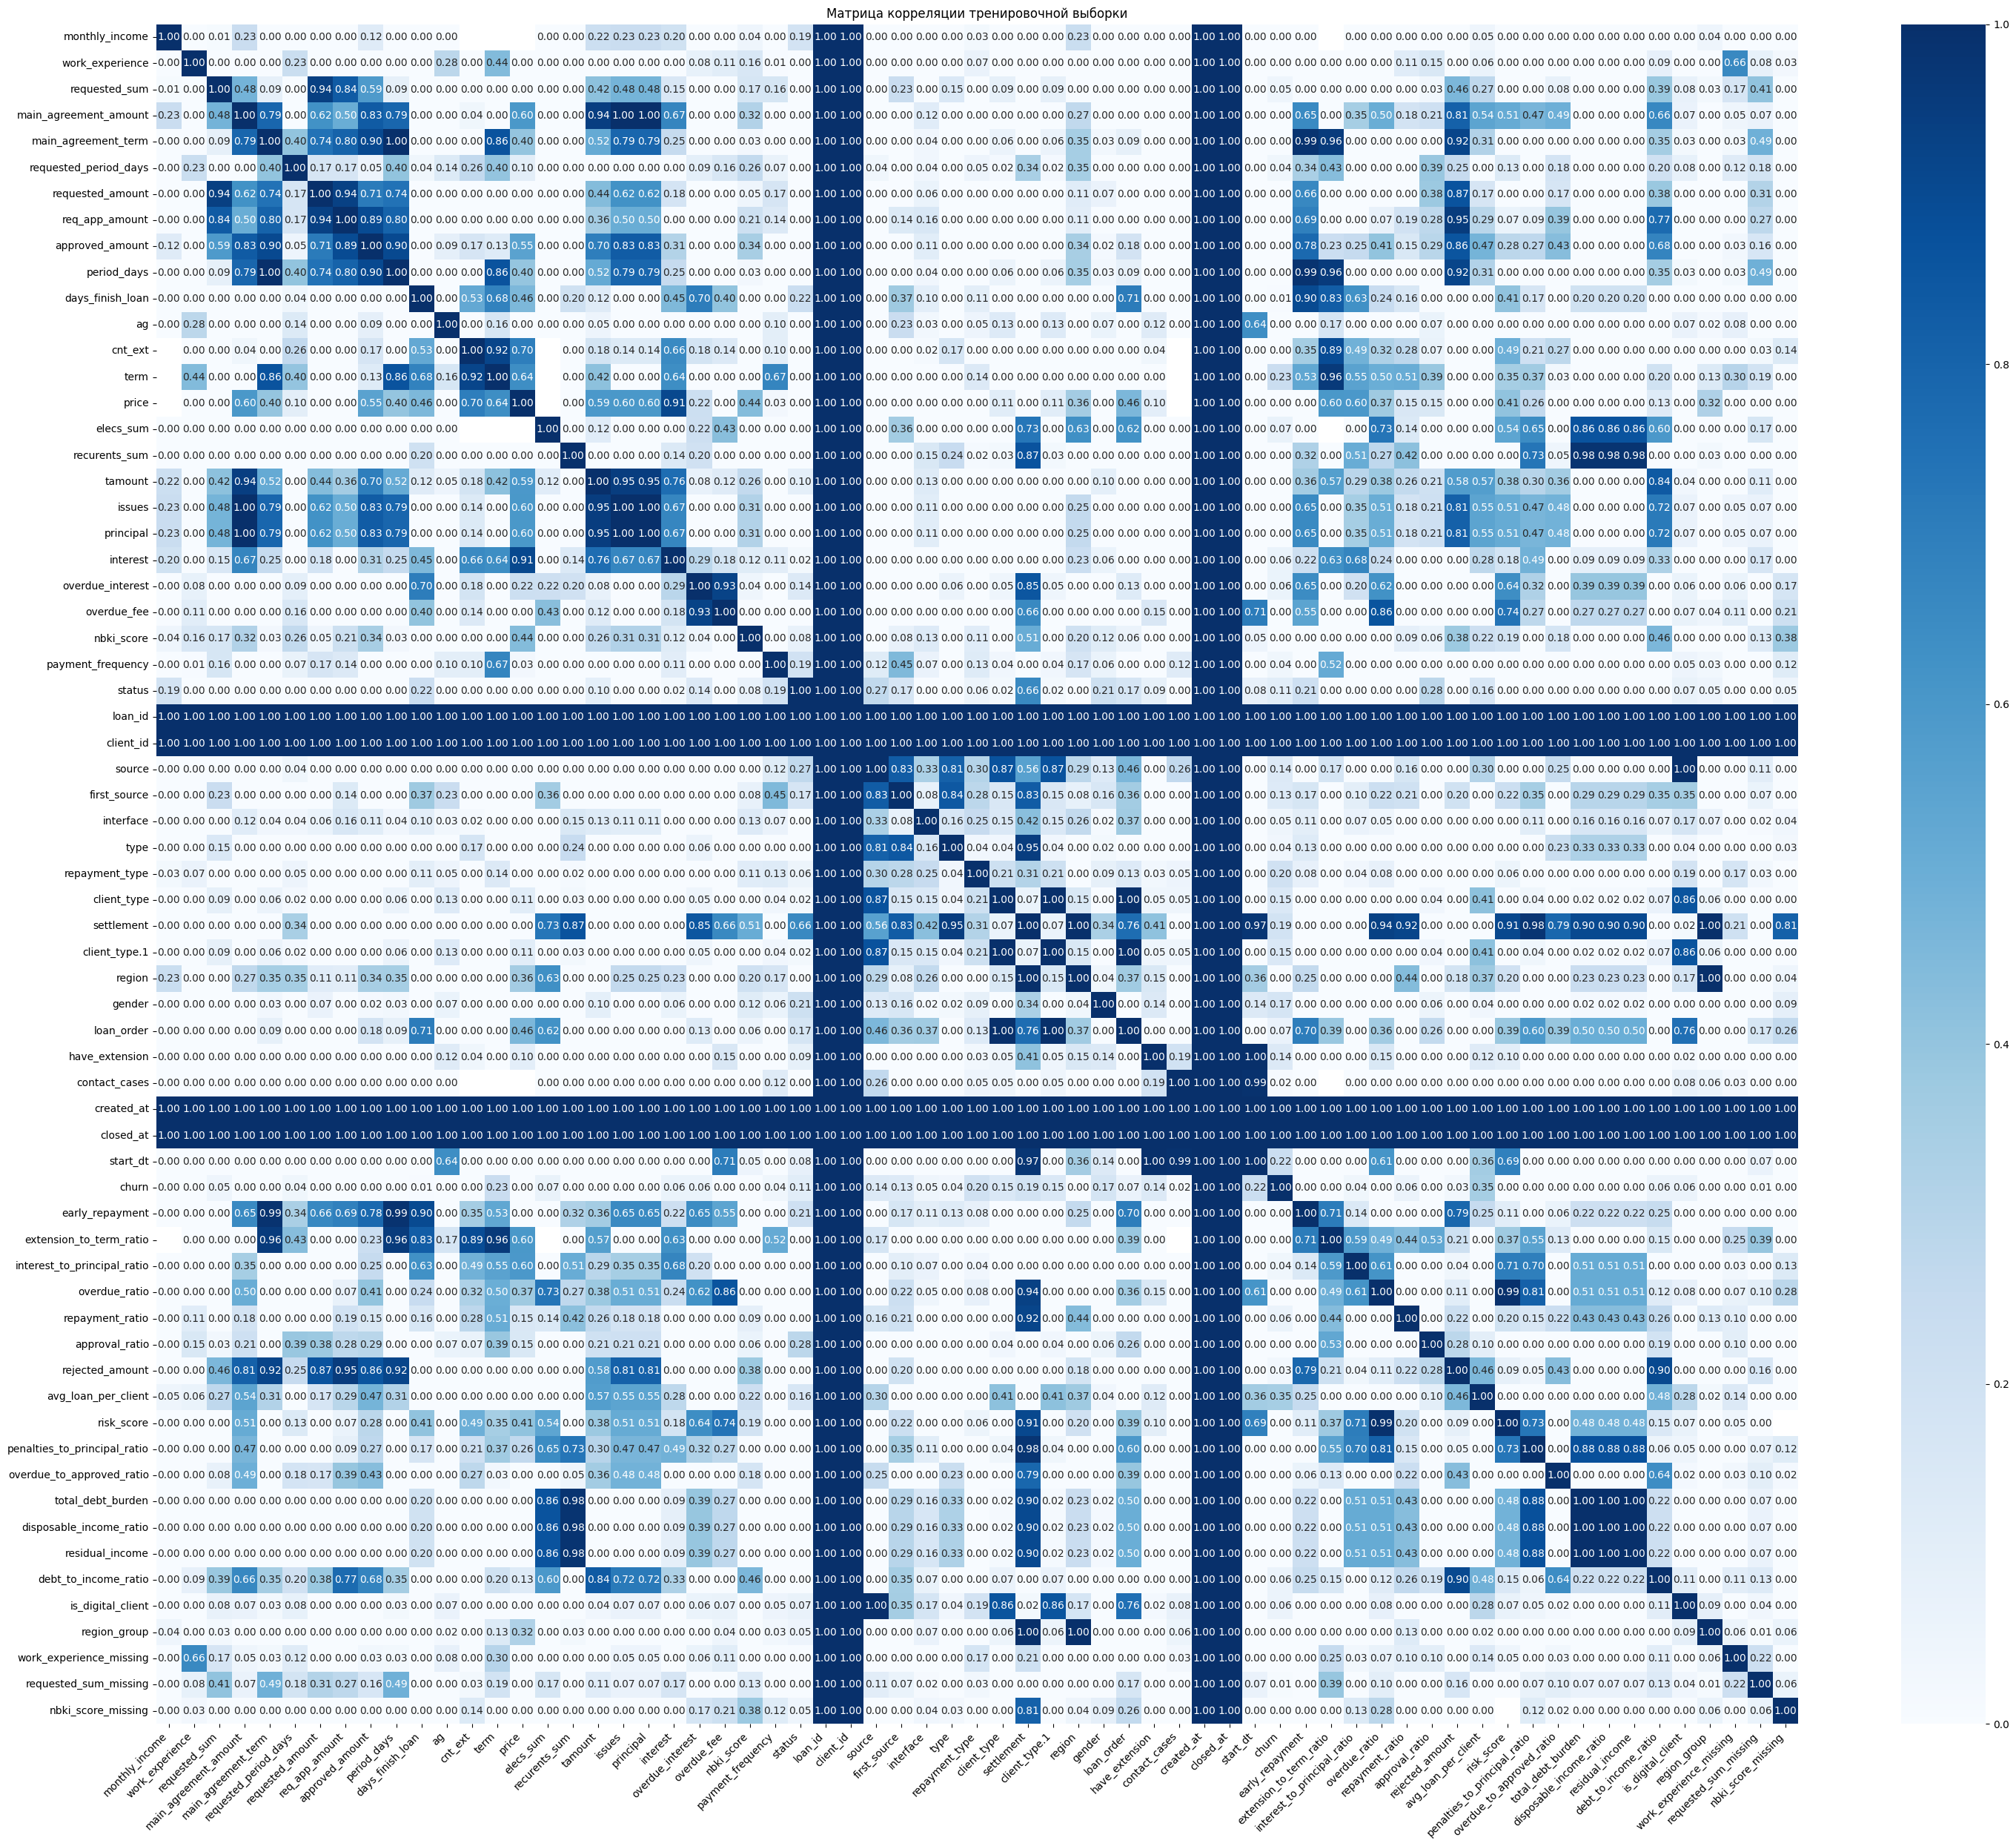

In [22]:
sample_train = train.sample(n=1000, random_state=42)

corr_train = sample_train.phik_matrix(
    interval_cols=['monthly_income', 'work_experience','requested_sum',
                   'main_agreement_amount','main_agreement_term',
                   'requested_period_days','requested_amount', 
                   'req_app_amount','approved_amount', 'period_days',
                   'days_finish_loan', 'ag', 'cnt_ext', 'term', 'price',
                   'elecs_sum', 'recurents_sum', 'tamount', 'issues',
                   'principal', 'interest', 'overdue_interest', 'overdue_fee',
                   'nbki_score', 'contact_cases', 'early_repayment',
                   'extension_to_term_ratio', 'payment_to_income_ratio',
                   'interest_to_principal_ratio', 'overdue_ratio',
                   'repayment_ratio',
                   'approval_ratio', 'rejected_amount', 'avg_loan_per_client',
                   'risk_score', 'penalties_to_principal_ratio',
                   'overdue_to_approved_ratio', 'total_debt_burden',
                   'disposable_income_ratio', 'residual_income',
                   'debt_to_income_ratio'])

plt.figure(figsize=(30,25))
heatmap = sns.heatmap(corr_train, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции тренировочной выборки')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
train['client_type.1'].unique()

array(['repeated', 'new'], dtype=object)

In [24]:
train['client_type'].unique()

array([1, 0])

Судя по матрице корреляции эти столбцы дублируют друг друга, один из них нужно удалить.

In [25]:
# Удаление мультиколлинеарных столбцов
train = train.drop(['closed_at', 'loan_id', 'client_id',
                    'main_agreement_amount', 'client_type.1'], axis=1)

In [26]:
train.fillna(0, inplace=True)

In [27]:
train.isna().sum()

monthly_income                  0
work_experience                 0
requested_sum                   0
main_agreement_term             0
requested_period_days           0
requested_amount                0
req_app_amount                  0
approved_amount                 0
period_days                     0
days_finish_loan                0
ag                              0
cnt_ext                         0
term                            0
price                           0
elecs_sum                       0
recurents_sum                   0
tamount                         0
issues                          0
principal                       0
interest                        0
overdue_interest                0
overdue_fee                     0
nbki_score                      0
payment_frequency               0
status                          0
source                          0
first_source                    0
interface                       0
type                            0
repayment_type

**Итоги раздела:**
1. В датафрейме `train` удалены выбросы и аномальные значения.
2. Столбцы с датами `created_at` и `start_dt` были  приведены к формату DateTime и затем отформатированы в кол-во секунд с начала эпохи.
3. Добавлены новые признаки.
4. В столбце `region` данные были почищены от лишних значений.
5. Добавлен новый признак с группами по регионам `region_group`.
6. Добавлены столбцы с метками пропущенных значений.
7. Создана функция для логичного заполнения пропущенных значений.
8. Построена матрица корреляции для всех признаков в датафрейме и на её основании удалены мультиколлинеарные признаки.
9. Оставшиеся пропущенные значения заменены на 0.

## Предобработка тестовой выборки

In [28]:
test_copy = test.copy()

In [29]:
test.isna().sum()

monthly_income                63
work_experience           885518
requested_sum            1184953
main_agreement_amount          0
main_agreement_term            0
requested_period_days     147861
requested_amount          138971
req_app_amount            138971
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  1197042
term                     1197042
price                    1197133
elecs_sum                   1984
recurents_sum               1984
tamount                      618
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 27977
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

In [30]:
missing_cols = ['work_experience', 'requested_sum', 'nbki_score']
for col in missing_cols:
    test[f'{col}_missing'] = test[col].isna().astype(int)

In [31]:
# Применение функций предобработки к тестовой выборке
test = clean_date(test)
test['region'] = test['region'].apply(clean_region_name)
test['region_group'] = test['region'].apply(group_regions)
test = fill_missing_values(test)

In [32]:
# Временные признаки
test['early_repayment'] = test['period_days'] - test['days_finish_loan']
test['extension_to_term_ratio'] = test['term'] / test['main_agreement_term']

# Платежное поведение
#test['payment_to_income_ratio'] = test['tamount'] / train['monthly_income']
test['interest_to_principal_ratio'] = test['interest'] / test['principal']
test['overdue_ratio'] = (test['overdue_interest'] + test['overdue_fee']) / test['principal']
test['repayment_ratio'] = (test['tamount'] - test['issues']) / test['tamount']

# Кредитное поведение
test['approval_ratio'] = test['approved_amount'] / test['requested_amount']
test['rejected_amount'] = test['requested_amount'] - test['approved_amount']
test['avg_loan_per_client'] = test.groupby('client_id')['approved_amount'].transform('mean')
test['is_first_extension'] = (test['cnt_ext'] == 1).astype(int)

# Признаки рискованности клиента
test['risk_score'] = (
        (test['nbki_score'] * -1) + 
        (test['overdue_ratio'] * 2) +
        (test['have_extension'] * 1.5)
    )
test['penalties_to_principal_ratio'] = (test['elecs_sum'] + test['recurents_sum']) / test['principal']
test['overdue_to_approved_ratio'] = test['issues'] / test['approved_amount']

# Финансовая нагрузка
test['total_debt_burden'] = (test['elecs_sum'] + test['recurents_sum']) / test['monthly_income']
test['disposable_income_ratio'] = 1 - test['total_debt_burden']
test['residual_income'] = test['monthly_income'] - (test['elecs_sum'] + test['recurents_sum'])
test['debt_to_income_ratio'] = (test['approved_amount'] + test['issues']) / test['monthly_income']

# Поведенческие признаки
test['is_digital_client'] = (test['source'].isin([11, 12]) | (test['interface'] == 'mobile')).astype(int)

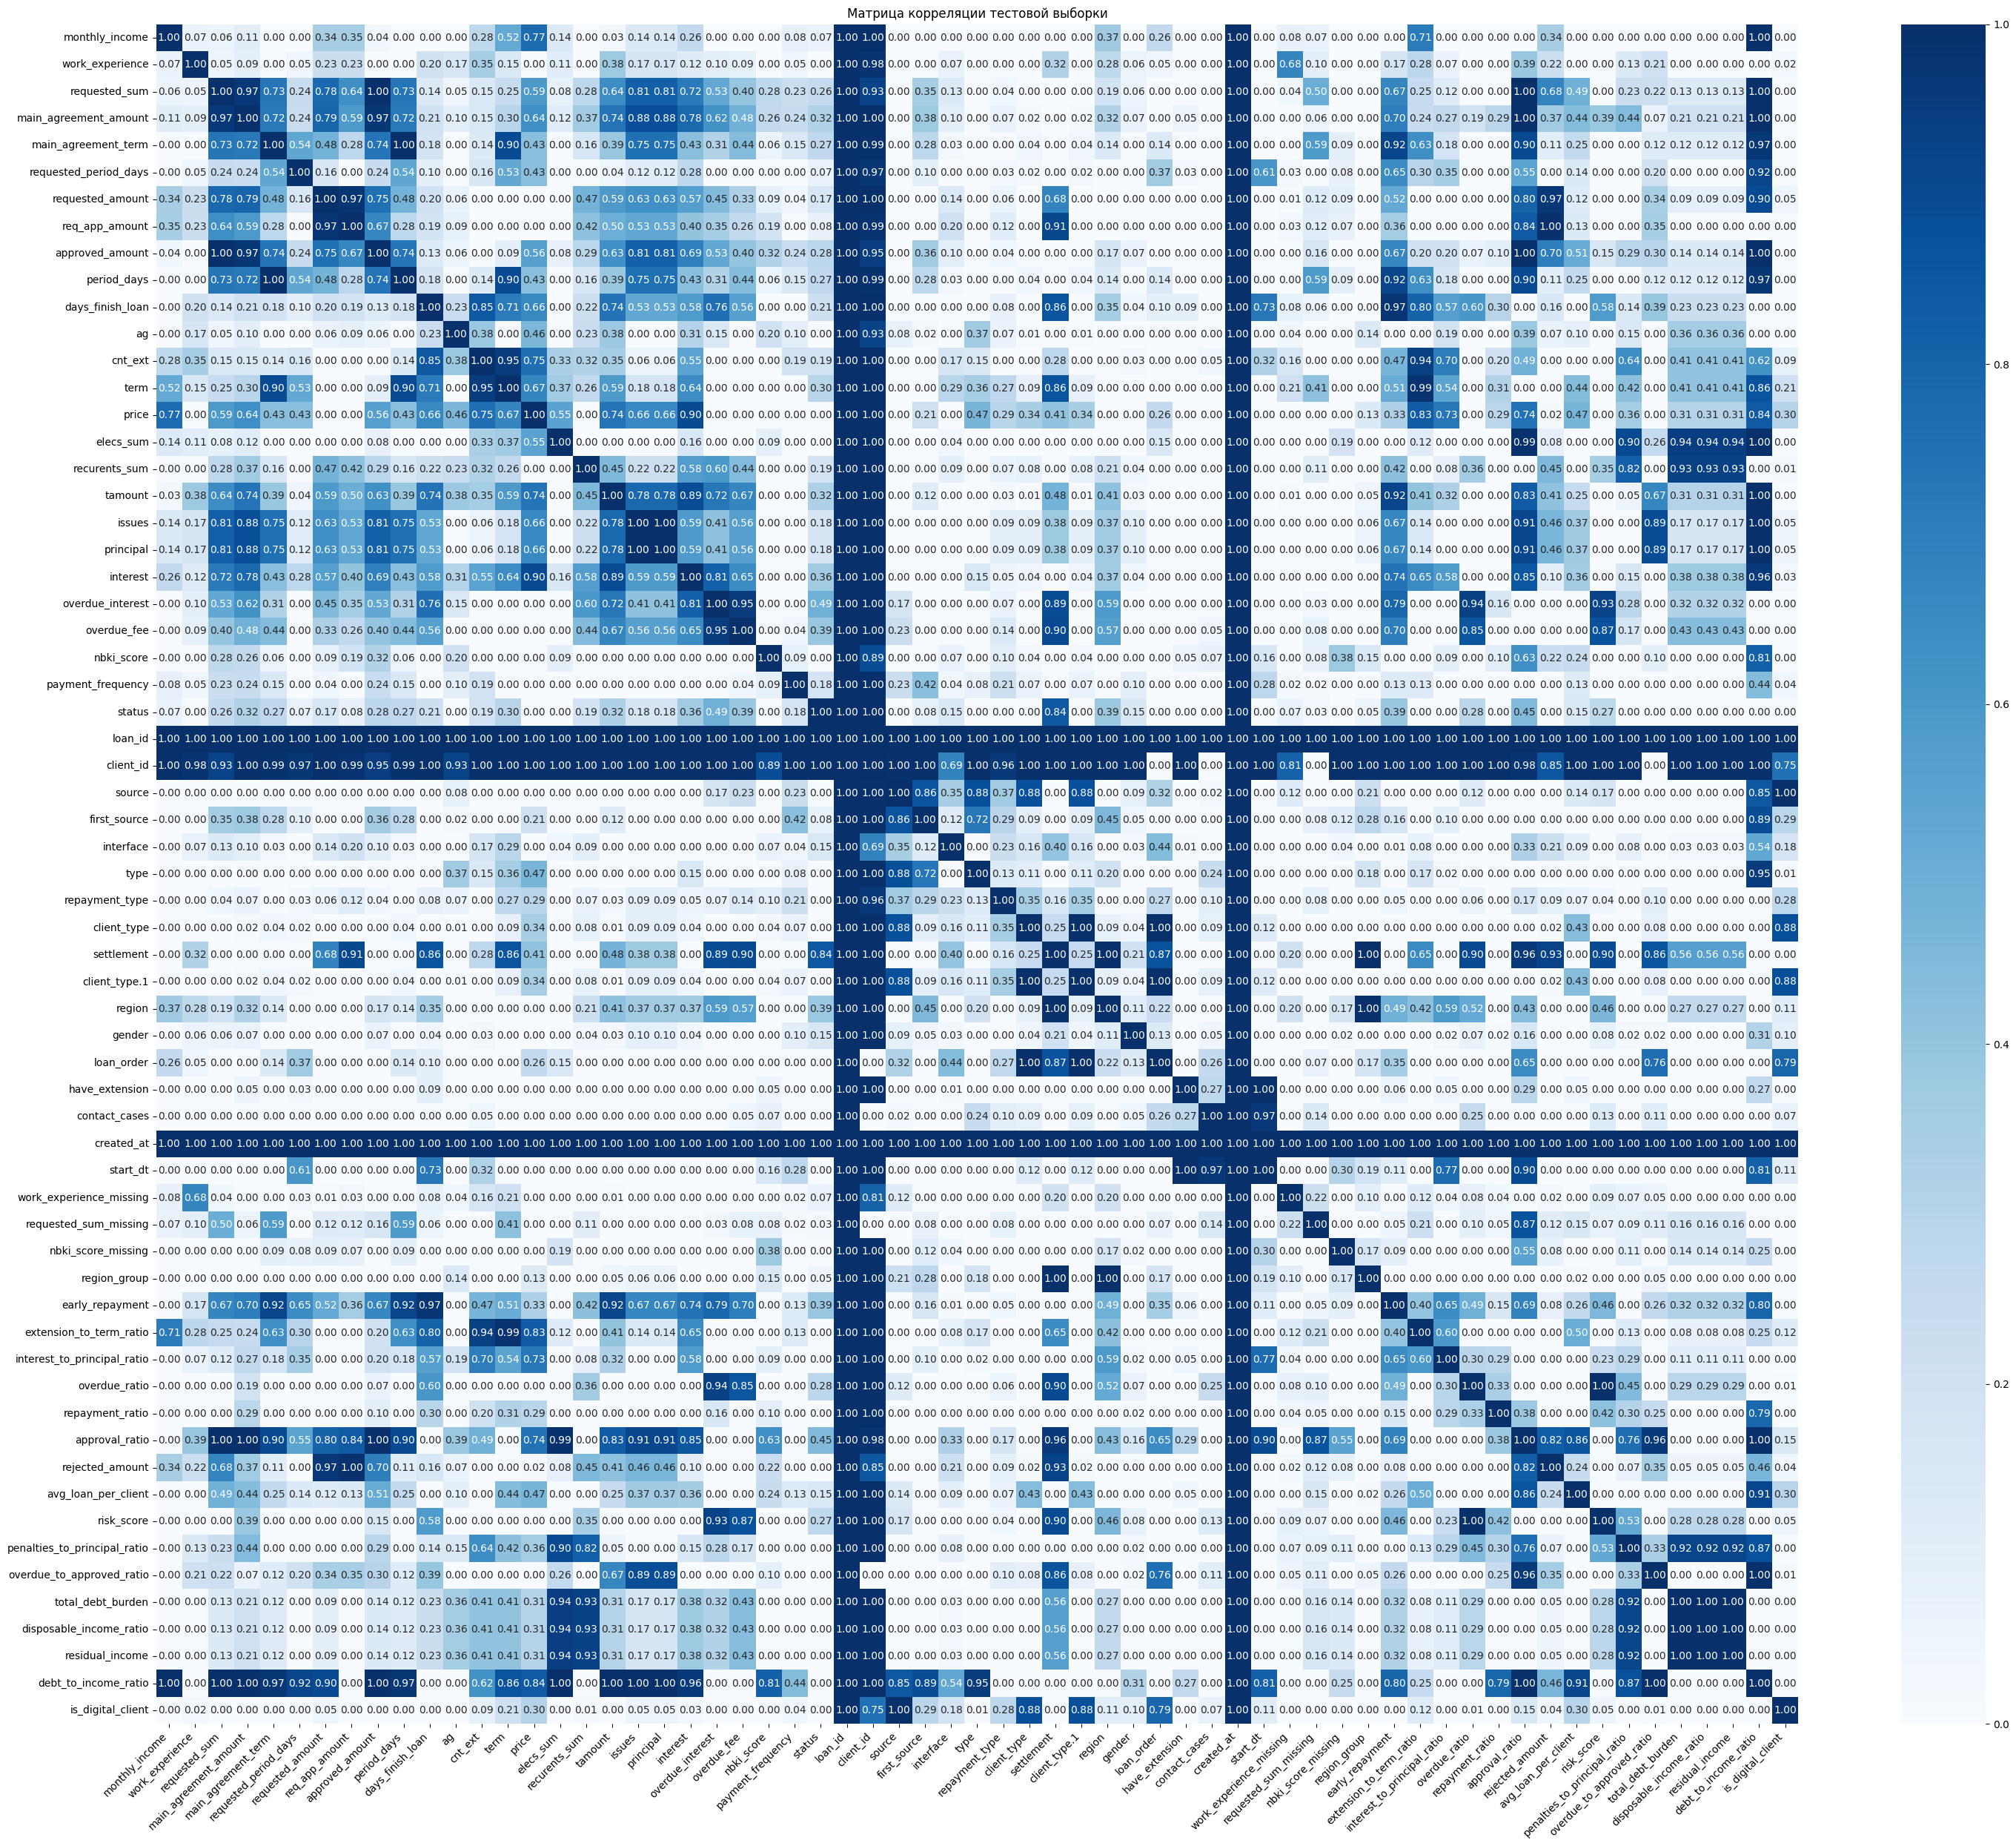

In [33]:
sample_test = test.sample(n=1000, random_state=42)

corr_test = sample_test.phik_matrix(
    interval_cols=['monthly_income', 'work_experience','requested_sum',
                   'main_agreement_amount','main_agreement_term',
                   'requested_period_days','requested_amount', 
                   'req_app_amount','approved_amount', 'period_days',
                   'days_finish_loan', 'ag', 'cnt_ext', 'term', 'price',
                   'elecs_sum', 'recurents_sum', 'tamount', 'issues',
                   'principal', 'interest', 'overdue_interest', 'overdue_fee',
                   'nbki_score', 'contact_cases', 'early_repayment',
                   'extension_to_term_ratio', 
                   'interest_to_principal_ratio', 'overdue_ratio',
                   'repayment_ratio', 'debt_to_income_ratio'
                   'approval_ratio', 'rejected_amount', 'avg_loan_per_client',
                   'risk_score', 'penalties_to_principal_ratio',
                   'overdue_to_approved_ratio', 'total_debt_burden',
                   'disposable_income_ratio', 'residual_income'])

plt.figure(figsize=(30,25))
heatmap = sns.heatmap(corr_test, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции тестовой выборки')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [34]:
test = test.drop(['loan_id', 'client_id', 'main_agreement_amount', 'client_type.1'], axis=1)

In [35]:
test.fillna(0, inplace=True)

In [36]:
test.isna().sum()

monthly_income                  0
work_experience                 0
requested_sum                   0
main_agreement_term             0
requested_period_days           0
requested_amount                0
req_app_amount                  0
approved_amount                 0
period_days                     0
days_finish_loan                0
ag                              0
cnt_ext                         0
term                            0
price                           0
elecs_sum                       0
recurents_sum                   0
tamount                         0
issues                          0
principal                       0
interest                        0
overdue_interest                0
overdue_fee                     0
nbki_score                      0
payment_frequency               0
status                          0
source                          0
first_source                    0
interface                       0
type                            0
repayment_type

**Итоги раздела:**
1. В датафрейме `test` проведены те же операции по очистке и обработке данных, что и в `train`: добавлены новые признаки и удалены мультиколлинеарные, обработаны столбцы с датами и заполнены пропущенные значения.

## Подготовка выборок для обучения моделей

In [37]:
X = train.drop(columns=['churn'])
y = train['churn']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

num_col = ['requested_sum', 'requested_period_days', 'days_finish_loan',
           'term', 'elecs_sum', 'interest', 'overdue_interest',
           'payment_frequency', 'status', 'source', 'first_source',
           'interface', 'type', 'repayment_type', 'client_type', 'loan_order',
           'have_extension', 'contact_cases',
           'interest_to_principal_ratio', 'repayment_ratio',
           'rejected_amount', 'avg_loan_per_client', 'debt_to_income_ratio',
           'is_digital_client', 'requested_sum_missing', 'created_at',
           'start_dt']

cat_col = ['gender', 'settlement', 'region_group', 'region']

scaler = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), num_col),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_col)],
    remainder='passthrough'
)

X_train_enc = scaler.fit_transform(X_train)
X_val_enc = scaler.transform(X_val)
X_test = test.replace([np.inf, -np.inf], 0)
X_test_enc = scaler.transform(X_test)

## Обучение моделей

In [38]:
def train_model(model, param_grid, model_name, results_df, sample_size=1_000_000):
    print(f"\nОбучение модели: {model_name}")

    # Сэмплируем данные для экономии вычислительных ресурсов
    n_rows = X_train_enc.shape[0]
    if sample_size < n_rows:
        sampled_indices = np.random.choice(n_rows, size=sample_size, replace=False)
        X_train_sampled = X_train_enc[sampled_indices]
        y_train_sampled = y_train.iloc[sampled_indices]
    else:
        X_train_sampled = X_train_enc
        y_train_sampled = y_train

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring='f1',
        cv=2,
        random_state=42,
        verbose=0,
        n_jobs=-1
    )

    search.fit(X_train_sampled, y_train_sampled)

    best_model = search.best_estimator_
    best_params = search.best_params_

    y_pred_train = best_model.predict(X_train_sampled)
    y_pred_val = best_model.predict(X_val_enc)

    train_f1 = f1_score(y_train_sampled, y_pred_train)
    val_f1 = f1_score(y_val, y_pred_val)

    print(f"\nЛучшие параметры для {model_name}: {best_params}")
    print(f"F1 на трейне: {train_f1:.4f}")
    print(f"F1 на валидации: {val_f1:.4f}")

    new_row = pd.DataFrame({
        'Модель': [model_name],
        'F1 на трейне': [train_f1],
        'F1 на валидации': [val_f1]
    })

    results_df = pd.concat([results_df, new_row], ignore_index=True)
    return best_model, results_df

results_df = pd.DataFrame(columns=['Модель', 'F1 на трейне', 'F1 на валидации'])

In [39]:
lgbm_params = {
    'n_estimators': [100, 300, 400],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.5],
    'num_leaves': [20, 31, 50]
}

lgbm_best, results_df = train_model(
    LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1),
    lgbm_params, "LightGBM", results_df)


Обучение модели: LightGBM

Лучшие параметры для LightGBM: {'num_leaves': 31, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.5}
F1 на трейне: 0.6821
F1 на валидации: 0.6493


In [40]:
cb_params = {
    'iterations': [50, 100], 
    'learning_rate': [0.01, 0.1],  
    'depth': [4, 6]
}

cb_best, results_df = train_model(
    CatBoostClassifier(random_state=42, verbose=0),
    cb_params, "CatBoost", results_df)


Обучение модели: CatBoost

Лучшие параметры для CatBoost: {'learning_rate': 0.1, 'iterations': 100, 'depth': 6}
F1 на трейне: 0.5512
F1 на валидации: 0.5489


In [41]:
xgb_params = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10]
}

xgb_best, results_df = train_model(
    XGBClassifier(random_state=42),
    xgb_params, "XGBoost", results_df)


Обучение модели: XGBoost

Лучшие параметры для XGBoost: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}
F1 на трейне: 0.5930
F1 на валидации: 0.5754


In [42]:
# Вывод таблицы с результатами
print("\nРезультаты обучения моделей:")
print(results_df)


Результаты обучения моделей:
     Модель  F1 на трейне  F1 на валидации
0  LightGBM      0.682052         0.649254
1  CatBoost      0.551173         0.548902
2   XGBoost      0.593010         0.575414


**Итоги раздела:**
- данные были закодированы и отмасштабированы;
- написана функция для обучения моделей;
- обучены 3 модели: `LGBMClassifier`, `CatBoostClassifier` и `XGBClassifier`;
- результаты их обучения добавлены в таблицу.

## Анализ обучения

Лучшей моделью оказалась `LightGBM`, её метрика F1 на валидации = 0.65

In [43]:
best_model = lgbm_best
y_pred_val = best_model.predict(X_val_enc)

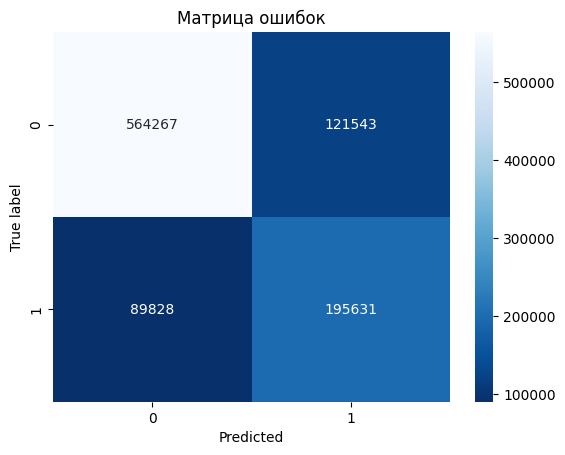

In [44]:
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

- Модель часто ошибочно классифицирует негативные примеры как позитивные, это ошибка первого рода, (FP) = 121543. То есть предсказывает, что клиент останется, хотя он уйдёт, это важная для бизнеса ошибка.
- Ошибок второго рода гораздо меньше, (FN) = 89828, но всё же они есть. То есть модель достаточно хорошо классифицирует позитивный класс.
- Для исправления ситуации можно настроить порог классификации.

In [45]:
# Подбор порога классификации
y_prob = best_model.predict_proba(X_val_enc)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f"Оптимальный порог: {best_threshold}")
print(f"Максимальное значение F1: {f1_scores[best_threshold_index]}")

y_pred = (y_prob >= best_threshold).astype(int)
final_f1 = f1_score(y_val, y_pred)
print(f"F1 с оптимальным порогом: {final_f1}")

Оптимальный порог: 0.5273993367931353
Максимальное значение F1: 0.650037401163323
F1 с оптимальным порогом: 0.650037401163323


In [46]:
# Применение порога классфикации к предсказаниям
y_test_prob = best_model.predict_proba(X_test_enc)[:, 1]
y_test_pred = (y_test_prob >= best_threshold).astype(int)

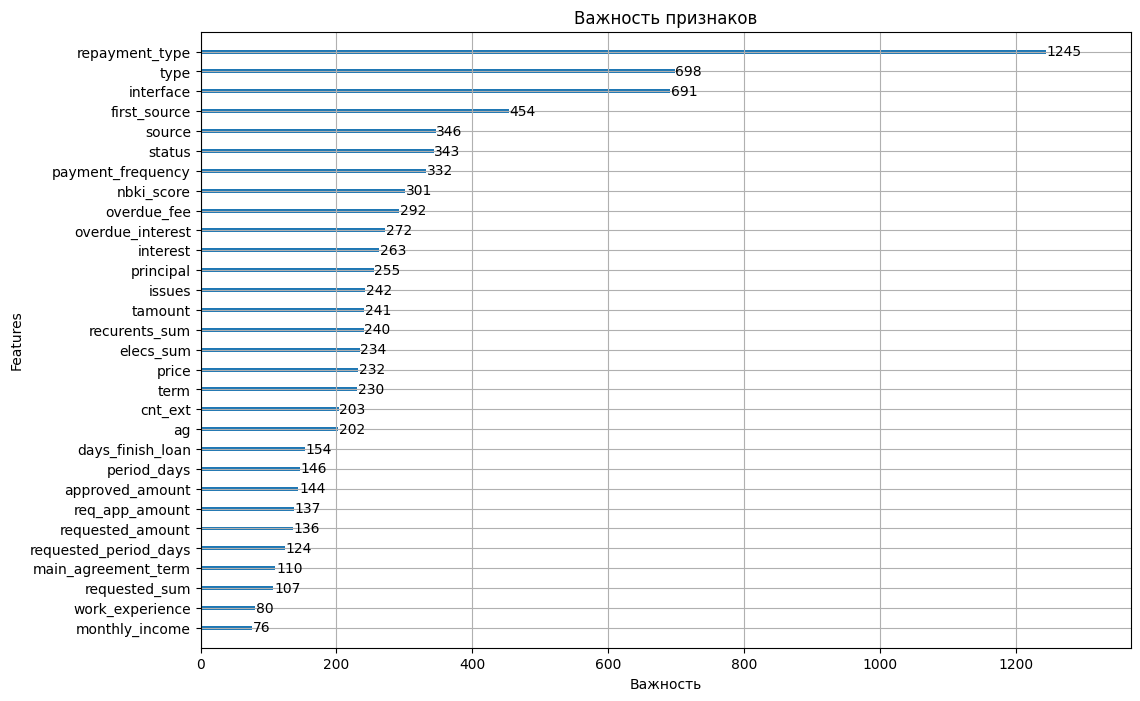

In [47]:
feature_names = X_train.columns.tolist()

fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(best_model, max_num_features=30, figsize=(12, 8), ax=ax)

ax.set_yticklabels(feature_names[:30])
ax.set_title("Важность признаков")
ax.set_xlabel("Важность")

plt.show()

In [48]:
# Создание датафрейма с предсказаниями
loan_id_submission = test_copy['loan_id']

submission = pd.DataFrame({
    'loan_id': loan_id_submission,
    'churn': y_test_pred
})

In [49]:
submission.to_csv('submission.csv', index=False)

## Общий вывод

### В этом проекте я проделала следующую работу:
1. Загрузила данные из 2-х датафреймов: `train` и `test`.
2. На основании гистограмм для всех числовых признаков были удалены выбросы.
3. Обработаны столбцы с датами.
4. Добавлены новые признаки.
5. Некорректные значения в столбце `region` были удалены.
6. Данные из столбца `region` были сгруппированы в новый столбец `region_group`.
7. С помощью функции `fill_missing_values` пропущенные значения в столбцах были логически заполнены.
8. Построена матрица корреляции между всеми признаками и на её основании удалены мультиколлинеарные столбцы.
9. Обучены 3 модели: `LGBMClassifier`, `CatBoostClassifier` и `XGBClassifier`.
10. Для лучшей модели была построена матрица ошибок, подобран порог классификации и оценена важность признаков.

### На основании проделанной работы можно сделать следующие выводы:
- данные имеют много пропусков;
- распределение таргета неравномерное, наблюдается значительный перекос в сторону 0 класса, т.е. наблюдений, где клиент остался значительно больше;
- лучшей оказалась модель `LGBMClassifier`, её метрика на валидационной выборке составила F1 = 0.65;
- самыми важными признаками при обучении модели оказались: `repayment_type`, `type`, `interface`, `first_source`, `source`, `status`, `payment_frequency`, `nbki_score`, `overdue_fee`, `overdue_interest`.

### Рекомендации:
1. Выяснить и устранить причину значительных пропусков в столбцах `work_experience`, `requested_sum`, `cnt_ext`, `term`, `price`, `contact_cases`, `start_dt`.
2. Подготовить для клиентов, которые предполагаемо уйдут, персональные предложения и акции с целью их удержания.